In [1]:
import sys
sys.path.append('../')
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.geometric import Geometric
from Code.envs.statemachine import make_batch
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict

from PIL import Image
import numpy as np



In [2]:
BATCH_SIZE = 64#128

USE_JIT = False

#TODO: test device
device = torch.device('cpu')

SEQ_LEN = 30
CHAR_DUR = 10 #0 #100
RESET_PROB = 0.1 #0.2

perm_num = 8#4
n_input = perm_num + CHAR_DUR
n_out = perm_num
n_control = 199#100
n_mem = 1#00#20 #100


In [3]:
spec2 = {'beta': 0.9,
   'lr': 0.001,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 1,
   'spkfn': 'ss',
   'decay_out': False,
   'architecture': '1L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Cooldown'}

spec = {'beta': 0.9,
   'lr': 0.01,
   'lr_decay': 0.8,
   '1-beta': False,
   'ported_weights': True,
   'NoBias': True,
   'iterations': 5000,
   'batch_size': 128,
   'mem_beta': 0.95,
   'spkfn': 'bellec',
   'decay_out': False,
   'architecture': '2L',
   'control_neuron': 'LIF',
   'mem_neuron': 'Adaptive'}

spec['iterations'] = 5000
#spec['mem_beta'] = 0.9985
#spec['mem_neuron'] = 'FlipFlop'
#spec['1-beta'] = 'improved'
spec['lr'] = 0.001
spec['lr_decay'] = 0.9
spec['beta'] = 0.8
spec['mem_beta'] = 0.8
spec['architecture'] = '1L'

ADAP_DECAY = np.exp(-1/CHAR_DUR)

In [4]:
from Code.everything3 import DynNetwork, OuterWrapper, BaseNeuron, SequenceWrapper, ParallelNetwork, \
 SeqOnlySpike, CooldownNeuron, OutputNeuron, LIFNeuron, NoResetNeuron, AdaptiveNeuron, FlipFlopNeuron, ParallelNetwork2


built_config = {
    'target_rate': 0.01,
    'BETA': spec['beta'],
    'OFFSET': 7, # TODO: was 3 for config24
    'SPIKE_FN': spec['spkfn'],
    '1-beta': spec['1-beta'],
    'ADAPDECAY': ADAP_DECAY, #0.9985,
    'ADAPSCALE': 180
}

#TODO: changed here
built_config['ADAPDECAY'] = 0.99

mem_config = {
    **built_config,
    'BETA': spec['mem_beta']
}



control_lookup = {
    'LIF': LIFNeuron,
    'Disc': SeqOnlySpike,
    'NoReset': NoResetNeuron
}

mem_lookup = {
    'Adaptive': AdaptiveNeuron,
    'Cooldown': CooldownNeuron,
    'NoReset': NoResetNeuron,
    'FlipFlop': FlipFlopNeuron
}

control_neuron = control_lookup[spec['control_neuron']](n_control, built_config)
mem_neuron = mem_lookup[spec['mem_neuron']](n_mem, mem_config)
out_neuron = OutputNeuron(n_control+n_mem, built_config) if spec['decay_out'] else BaseNeuron(n_control+n_mem, built_config)


loop_2L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop_2L = OrderedDict([
    ('input', (n_input, 0.1)),
    ('control', [[('input', 0.8), ('mem', 0.2)], control_neuron, nn.Linear]),
    ('mem', [['control'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])


loop_1L = OrderedDict([
    ('input', n_input),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop_1L = OrderedDict([
    ('input', (n_input, 2/n_input)),
    ('control', [['input', 'control', 'mem'], control_neuron, nn.Linear]),
    ('mem', [['input', 'control', 'mem'], mem_neuron, nn.Linear]),
    ('output', [['control', 'mem'], out_neuron, None]),
])

loop = loop_1L if spec['architecture'] == '1L' else loop_2L

outer = OrderedDict([
    ('input', n_input),
    ('loop', [['input'], SequenceWrapper(ParallelNetwork2(loop, bias=(not spec['NoBias']))), None]),
    ('output', [['loop'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device)


#loop_model = OuterWrapper(make_SequenceWrapper(ParallelNetwork(loop), USE_JIT), device, USE_JIT)

#final_linear = nn.Linear(n_control+n_mem, 10).to(device)
'''
if spec['ported_weights']:
    o_weights = pickle.load(open('weight_transplant_enc', 'rb'))

    o1 = torch.tensor(o_weights['RecWeights/RecurrentWeight:0']).t()
    o2 = torch.tensor(o_weights['InputWeights/InputWeight:0']).t()
    o3 = torch.cat((o2, o1), dim=1)
    with torch.no_grad():
        model.pretrace.layers.loop.model.layers.control_synapse.weight.data[:,:300] = o3[:120] if spec['architecture'] == '1L' else o3[:120, :181]
        model.pretrace.layers.loop.model.layers.mem_synapse.weight.data[:,:300] = o3[120:] if spec['architecture'] == '1L' else o3[120:, 180:]
        model.pretrace.layers.output_synapse.weight.data = torch.tensor(o_weights['out_weight:0']).t()
'''
params = list(model.parameters())

model.to(device)


OrderedDict([('control', [[('input', 1), ('control', 1), ('mem', 1)], LIFNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('mem', [[('input', 1), ('control', 1), ('mem', 1)], AdaptiveNeuron(), <class 'torch.nn.modules.linear.Linear'>]), ('output', [[('control', 1), ('mem', 1)], BaseNeuron(), None])])


OuterWrapper(
  (model): DynNetwork(
    (layers): ModuleDict(
      (loop): SequenceWrapper(
        (model): ParallelNetwork2(
          (layers): ModuleDict(
            (control): LIFNeuron()
            (control_synapse): Linear(in_features=218, out_features=199, bias=True)
            (mem): AdaptiveNeuron()
            (mem_synapse): Linear(in_features=218, out_features=1, bias=True)
            (output): BaseNeuron()
          )
        )
      )
      (output_synapse): Linear(in_features=200, out_features=8, bias=True)
      (output): BaseNeuron()
    )
  )
)

In [5]:
'''
from Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron

lstm_size = 32

outer = OrderedDict([
    ('input', n_input),
    ('lstm', [['input'], LSTMWrapper(n_input, lstm_size), None]),
    ('output', [['lstm'], BaseNeuron(n_out, None), nn.Linear]),
])

model = OuterWrapper(DynNetwork(outer), device, USE_JIT)

#with torch.no_grad():
#    model.model.layers.lstm.lstm.bias_hh_l0[:256] += 3



params = list(model.parameters())


model.to(device)
'''

"\nfrom Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron\n\nlstm_size = 32\n\nouter = OrderedDict([\n    ('input', n_input),\n    ('lstm', [['input'], LSTMWrapper(n_input, lstm_size), None]),\n    ('output', [['lstm'], BaseNeuron(n_out, None), nn.Linear]),\n])\n\nmodel = OuterWrapper(DynNetwork(outer), device, USE_JIT)\n\n#with torch.no_grad():\n#    model.model.layers.lstm.lstm.bias_hh_l0[:256] += 3\n\n\n\nparams = list(model.parameters())\n\n\nmodel.to(device)\n"

In [6]:
'''
from Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron
model = OuterWrapper(torch.load('../models/perm_lstm2'), device, USE_JIT)
params = list(model.parameters())
'''

"\nfrom Code.everything3 import DynNetwork, OuterWrapper, LSTMWrapper, MeanModule, BaseNeuron\nmodel = OuterWrapper(torch.load('../models/perm_lstm2'), device, USE_JIT)\nparams = list(model.parameters())\n"

In [7]:
lr = spec['lr']
optimizer = optim.Adam(params, lr=lr)
#bce = nn.BCEWithLogitsLoss(reduction='none')
ce = nn.CrossEntropyLoss() #reduction='none'


ITERATIONS = spec['iterations']#36000

In [8]:
seql = 100

with torch.no_grad():
    nrythm = torch.diag(torch.ones([CHAR_DUR], device=device))
    #nrythm *= 0
    nrythm = nrythm.expand(seql, CHAR_DUR, CHAR_DUR).reshape(seql*CHAR_DUR, 1, CHAR_DUR).expand(seql*CHAR_DUR, BATCH_SIZE, CHAR_DUR)

def validate():
    #seql = SEQ_LEN
    with torch.no_grad():
        input, raw_inp = make_batch(BATCH_SIZE, seql, device, perm_num)
        input = input.repeat_interleave(CHAR_DUR, 0)
        input = torch.cat((input, nrythm), dim=-1)

        #TODO: repeat data over

        output, _ = model(input)
        output = output.view(seql, CHAR_DUR, BATCH_SIZE, perm_num).mean(dim=1)
        out_class = output.argmax(dim=-1, keepdim=True)
        targets = lookup[out_class, raw_inp]
        #print(out_class[3, 0, 0], raw_inp[3, 0, 0], out_class[4, 0, 0])
        acc = (out_class[1:] == targets[:-1]).float().mean().item()
        print('Validation: ', acc)

stats = {
    'grad_norm': [],
    'loss': [],
    'acc': [],
    'batch_var': [],
    'val': []
}

grad_norm_history = []
def record_norm():
    norms = []
    for p in params:
        norms.append(p.grad.norm().item())
    stats['grad_norm'].append(torch.tensor(norms).norm().item())


In [9]:
with torch.no_grad():
    lookup = torch.empty((perm_num, perm_num), device=device, dtype=torch.long)
    for i in range(perm_num):
        lookup[i] = torch.randperm(perm_num)

In [10]:
with torch.no_grad():
    rythm = torch.diag(torch.ones([CHAR_DUR], device=device))
    #rythm *= 0
    rythm = rythm.expand(SEQ_LEN, CHAR_DUR, CHAR_DUR).reshape(SEQ_LEN*CHAR_DUR, 1, CHAR_DUR).expand(SEQ_LEN*CHAR_DUR, BATCH_SIZE, CHAR_DUR)


start = time.time()
i = 1
sumloss = 0
sumacc = 0

while i < ITERATIONS:
    batchstart = time.time()
    optimizer.zero_grad()
    input, raw_inp = make_batch(BATCH_SIZE, SEQ_LEN, device, perm_num)
    #data = data.repeat_interleave(CHAR_DUR, 0)

    input = input.repeat_interleave(CHAR_DUR, 0)
    input = torch.cat((input, rythm), dim=-1)

    #TODO: repeat data over

    output, _ = model(input)
    output = output.view(SEQ_LEN, CHAR_DUR, BATCH_SIZE, perm_num).mean(dim=1)
    out_class = output.argmax(dim=-1, keepdim=True)
    targets = lookup[out_class, raw_inp]

    loss = ce(output[1:].view(-1, perm_num), targets[:-1].view(-1))

    loss.backward()
    optimizer.step()

    acc = (out_class[1:] == targets[:-1]).float().mean().item()



    with torch.no_grad():
        record_norm()
        stats['loss'].append(loss.item())
        #acc = ((((output > 0).float() == target).float()*recall).sum()/recall.sum()).item()
        #stats['acc'].append(acc)
        batch_var = 3 #out_final.var(0).mean().item()
        #stats['batch_var'].append(batch_var)

        #print(loss.item(), acc1, acc2)


    sumloss += loss.item()
    sumacc += acc
    if i%20 == 0:
        print(sumacc/20, i)
        #print(loss.item(), sumloss/20, sumacc/20, time.time()-batchstart, batch_var) #torch.argmax(outputs[-1], 1).float().var()
        sumloss = 0
        sumacc = 0
    if i%100 == 0:
        validate()
    if i%2500 == 0:
        lr = lr * spec['lr_decay']
        optimizer = optim.Adam(params, lr=lr)
        print('Learning Rate: ', lr)
    i += 1
    #config['stats'] = stats
    #config['progress'] = i
    #with open('configs/' + run_id + '.json', 'w') as config_file:
    #    json.dump(config, config_file, indent=2)
    #model.save('models/'+run_id)


print('Total time: ', time.time()-start)


0.18863146491348742 20
0.29485452473163604 40
0.2922144390642643 60
0.3505118519067764 80
0.4067887932062149 100
Validation:  0.4089330732822418
0.4569504290819168 120
0.49636314809322357 140
0.5185614287853241 160
0.5183459013700485 180
0.5365571111440659 200
Validation:  0.5172032713890076
0.5409482657909394 220
0.5659213364124298 240
0.5955549597740173 260
0.629175654053688 280
0.6435614198446273 300
Validation:  0.6635100841522217
0.684859910607338 320
0.699326503276825 340
0.7222791016101837 360
0.748464435338974 380
0.7685883641242981 400
Validation:  0.7695707082748413
0.7835398703813553 420
0.8225484907627105 440
0.849649778008461 460
0.8687769383192062 480
0.8779903024435043 500
Validation:  0.9034090638160706
0.8777209013700485 520
0.896821117401123 540
0.9111530125141144 560
0.9157058268785476 580
0.9389277964830398 600
Validation:  0.9469696879386902
0.9425377190113068 620
0.9483566761016846 640
0.9515625029802323 660
0.9564655125141144 680
0.9604525834321975 700
Validation

KeyboardInterrupt: 

In [ ]:
validate()


In [ ]:
lookup

In [11]:
with torch.no_grad():
    input, raw_inp = make_batch(BATCH_SIZE, seql, device, perm_num)
    input = input.repeat_interleave(CHAR_DUR, 0)
    input = torch.cat((input, nrythm), dim=-1)

    #TODO: repeat data over

    output, _, log = model(input, logging=True)

ar_length = input.shape[0]
array_list = [input, log['loop']['control'], log['loop']['mem'], log['output']] #log['loop']['output']
array_list2 = []
for ar in array_list:
    array_list2.append(ar[:, 0])
    array_list2.append(torch.ones((ar_length, 1), device=input.device) * 0.5)
big_ar = torch.cat(array_list2[:-1], dim=1).detach() * 255
img = Image.fromarray(big_ar.numpy().astype(np.uint8), 'L')

In [12]:
img.size

(229, 1000)

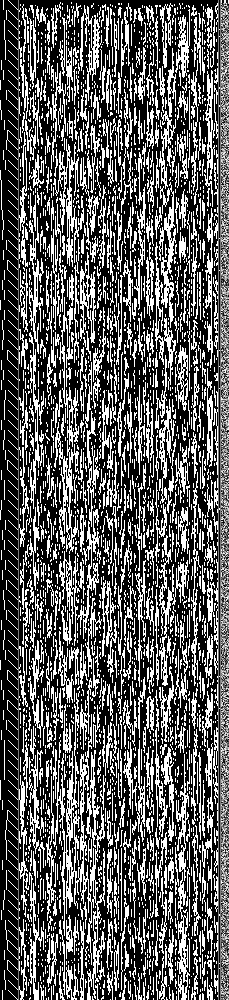

In [13]:
img
#img.resize((229, 500))

In [14]:
log['loop']['control'].mean()

tensor(0.3830)

In [ ]:
log['loop']['mem'].mean()



In [ ]:
model.model.layers.loop.model.layers.control_synapse.weight.var()

In [ ]:
model.model.layers.loop.model.layers.mem_synapse.weight.var()

In [ ]:
model.model.layers.loop.model.layers.control_synapse.weight.var() * log['loop']['mem'].mean()


In [ ]:
#model.save('../models/state_adaptive1')